# Finetuning using Unsloth for Automated Essay Scoring using Open-Source LLM

## 1. Install Required Dependencies

In [1]:
!pip install -q -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q -U unsloth datasets trl peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 44.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.6 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.0 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.7 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 4.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 3.1 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 8.4 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 11.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.8 MB/s eta 0:00:00


## 2. Set Up Environment & Imports

In [2]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from datasets import Dataset
from sklearn.metrics import cohen_kappa_score, mean_squared_error, accuracy_score, confusion_matrix
from scipy.stats import spearmanr
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import TrainingArguments
from trl import SFTTrainer


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## 3. Load Dataset
- Reads train, validation, and test datasets from an Excel file.
- Resets indices to avoid issues when applying functions.

In [3]:
data_path = "/kaggle/input/cleaned-automated-essay-grader/train_test_data.xlsx"
train_df = pd.read_excel(data_path, sheet_name="Train")
val_df = pd.read_excel(data_path, sheet_name="Validation")
test_df = pd.read_excel(data_path, sheet_name="Test")

# Reset indices
X_train, X_eval, X_test = train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [4]:
X_train

,essay_id,full_text,score
0,678631b,I think that we should not have that in are cl...,1
1,c6db974,I believe that driverless are something that s...,4
2,b5962cc,"In foreign countries, residents appear to pref...",1
3,d5f4814,"In this article ""making Mona Lisa Smile"", it t...",5
4,4332440,that people can still steer and accelerte and ...,1
...,...,...,...
773,31e00b5,"""With less cars we have less accidents and les...",4
774,efd13e6,Have you ever thought about what life would be...,4
775,4d00492,"Dear Senator,\n\nConcerning the topic of the m...",6
776,178f445,In the 21st century there has\n\nbeen a lot of...,5


In [5]:
X_eval

,essay_id,full_text,score
0,21e1fd4,"Senator <blank>,\n\nI would like to express my...",3
1,0435f85,The author didnt support this claim very well....,3
2,7fa6c4e,Luke was 18 years old. He just finished his hi...,1
3,5ac9060,I am completely against driverless cars. There...,4
4,ccc4a3b,State senator.....Keeping the Electoral Colleg...,1
...,...,...,...
92,7044865,Everyday when you wake up and get ready for wo...,5
93,70bb147,Are Driverless Cars the Future or Death to Man...,3
94,ce0be14,I think other should participate in the Seagoi...,2
95,6271110,The Electoral College is a system that must be...,6


In [6]:
X_test

,essay_id,full_text,score
0,459922f,"cars, they wernt invented in the old days. who...",2
1,78569ca,Limiting car usage would be a wise thing to do...,2
2,fad3429,Since World War II we have been heavily depend...,5
3,1bdcde3,"In ""The challenge of the Exploring Venus"" it s...",3
4,b6994cb,"The Electoral College, established by the Foun...",6
...,...,...,...
93,2aca278,One big milestone in a person's teenage years ...,5
94,680c26b,Driverless cars are a thing of the future. The...,5
95,9e1909b,Politicians and the public have argued for yea...,5
96,98bbdf1,The electoral college is an institution that h...,5


## 4. Generate Prompts for Fine-Tuning

In [7]:
def generate_prompt(data_point):
    return f"""
            Evaluate the following essay using a **1 to 6** scoring scale.

            **Scoring Criteria:**
            - **6** = Excellent: Insightful, well-structured, strong evidence, minimal errors.
            - **5** = Good: Clear, logical, solid evidence, mostly error-free.
            - **4** = Satisfactory: Adequate reasoning, relevant examples, minor issues.
            - **3** = Developing: Some reasoning, weak structure, noticeable errors.
            - **2** = Poor: Vague argument, poor organization, frequent errors.
            - **1** = Very weak: No clear argument, incoherent, major issues.

            **Essay:**
            "{data_point['full_text']}"

            **Assign a final score (1 to 6) based on the criteria above.**
            - **Return the number first then the explanation.**

            **Assigned Score:** {data_point['score']}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Evaluate the following essay using a **1 to 6** scoring scale.

            **Scoring Criteria:**
            - **6** = Excellent: Insightful, well-structured, strong evidence, minimal errors.
            - **5** = Good: Clear, logical, solid evidence, mostly error-free.
            - **4** = Satisfactory: Adequate reasoning, relevant examples, minor issues.
            - **3** = Developing: Some reasoning, weak structure, noticeable errors.
            - **2** = Poor: Vague argument, poor organization, frequent errors.
            - **1** = Very weak: No clear argument, incoherent, major issues.

            **Essay:**
            "{data_point['full_text']}"

            **Assign a final score (1 to 6) based on the criteria above.**
            - **Return the number first then the explanation.**

            **Final Score:** 
            """.strip()

For test set, use `generate_test_prompt()` for `X_test` to avoid leaking the true score into the prompt. This ensures that the model is making predictions without being influenced by the actual labels.

In [8]:
# Apply the prompt generation functions
X_train['prompt'] = X_train.apply(generate_prompt, axis=1)
X_eval['prompt'] = X_eval.apply(generate_prompt, axis=1)
X_test['prompt'] = X_test.apply(generate_test_prompt, axis=1)

# Only keep the prompt column
train_data = Dataset.from_pandas(X_train[['prompt']])
eval_data = Dataset.from_pandas(X_eval[['prompt']])
test_data = Dataset.from_pandas(X_test[['prompt']])

In [9]:
train_data[0]

{'prompt': 'Evaluate the following essay using a **1 to 6** scoring scale.\n\n            **Scoring Criteria:**\n            - **6** = Excellent: Insightful, well-structured, strong evidence, minimal errors.\n            - **5** = Good: Clear, logical, solid evidence, mostly error-free.\n            - **4** = Satisfactory: Adequate reasoning, relevant examples, minor issues.\n            - **3** = Developing: Some reasoning, weak structure, noticeable errors.\n            - **2** = Poor: Vague argument, poor organization, frequent errors.\n            - **1** = Very weak: No clear argument, incoherent, major issues.\n\n            **Essay:**\n            "I think that we should not have that in are classes because that would make people fill unhappy to come to school. Then that wouldamke people not want to come to school because the teachers would know how we are filling today and whats on our minds. Then they would know what we are thinking. Then they would know when we are happy, whe

In [10]:
test_data[0]

{'prompt': 'Evaluate the following essay using a **1 to 6** scoring scale.\n\n            **Scoring Criteria:**\n            - **6** = Excellent: Insightful, well-structured, strong evidence, minimal errors.\n            - **5** = Good: Clear, logical, solid evidence, mostly error-free.\n            - **4** = Satisfactory: Adequate reasoning, relevant examples, minor issues.\n            - **3** = Developing: Some reasoning, weak structure, noticeable errors.\n            - **2** = Poor: Vague argument, poor organization, frequent errors.\n            - **1** = Very weak: No clear argument, incoherent, major issues.\n\n            **Essay:**\n            "cars, they wernt invented in the old days. who needs them, not me. screw cars. Ill tell u what u need to know about life and transportation. We can limit car use if u just use this information and use it in your life.\n\nparis has so much smog. Ew!!! No one likes that so lets limit car use. paris has 147 micrograms of matter in cubic 

## 5. Define Evaluation Metrics
- Implements Quadratic Weighted Kappa (QWK) and Spearman’s Rank Correlation to measure model agreement with human graders.
- Prints a confusion matrix for error analysis.

In [11]:
def compute_metrics(y_true, y_pred):
    """
    Computes evaluation metrics: QWK, Spearman’s Rank Correlation, MSE, Accuracy, and Soft Accuracy.

    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.

    Returns:
        dict: Dictionary of metric results.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute Soft Accuracy: proportion of predictions within ±1 of the true label
    soft_acc = np.mean(np.abs(y_true - y_pred) <= 1)

    metrics = {
        "QWK": cohen_kappa_score(y_true, y_pred, weights="quadratic"),
        "Spearman Correlation": spearmanr(y_true, y_pred)[0],  # Returns (corr, p-value), retrieve corr
        "MSE": mean_squared_error(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Soft Accuracy": soft_acc,
    }

    return metrics 

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots the confusion matrix.

    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
        labels (list): Label categories.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    labels = np.array(labels)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def evaluate(y_true, y_pred):
    """
    Evaluate model predictions using QWK, Spearman’s Rank Correlation, Accuracy, Soft Accuracy, 
    and visualize the confusion matrix.

    Args:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
    """
    metrics = compute_metrics(y_true, y_pred)

    print(f'Quadratic Weighted Kappa: {metrics["QWK"]:.3f}')
    print(f"Spearman's Rank Correlation: {metrics['Spearman Correlation']:.3f}")
    print(f'Accuracy: {metrics["Accuracy"]:.3f}')
    print(f'Soft Accuracy: {metrics["Soft Accuracy"]:.3f}')

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

## 6. Load LLM Model with Unsloth

In [12]:
max_seq_length = 2048  
dtype = None  # Auto-detect
load_in_4bit = True  # Use 4-bit quantization to reduce memory usage.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

# Set padding token
tokenizer.pad_token_id = tokenizer.eos_token_id

==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu118. CUDA: 6.0. CUDA Toolkit: 11.8. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

## 7. Apply LoRA to Model

In [13]:
model = FastLanguageModel.get_peft_model(
    model,
    r=64,  # Suggested: 8, 16, 32, 64, 128
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0.1,  
    bias="none",
    # use_gradient_checkpointing="unsloth",  # Optimized for long context
    random_state=42,
    use_rslora=False,  # Rank Stabilized LoRA disabled
    loftq_config=None,  # LoftQ disabled
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.3.9 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [14]:
def tokenize_function(examples):
    return tokenizer(examples["prompt"], padding="max_length", truncation=True, max_length=max_seq_length)

# Apply tokenization
train_data = train_data.map(tokenize_function, batched=True)
eval_data = eval_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/778 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

In [15]:
output_dir = "trained_weights"  # Directory to save model checkpoints

training_arguments = TrainingArguments(
    output_dir="trained_weights",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    eval_accumulation_steps=4,
    # gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    save_steps=10,
    save_total_limit=2,
    logging_steps=1,  # Log training loss at each step
    logging_dir="trained_weights/logs",
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=False,
    lr_scheduler_type="cosine",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",  # Ensure logs appear per step
    log_level="info",  # Set logging to show detailed output
    disable_tqdm=False,  # Force showing progress bar
    report_to="none",  # Avoid using wandb
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_data,
    eval_dataset=eval_data,
    dataset_text_field="prompt",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can speed up training for short sequences
    args=training_arguments,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using auto half precision backend


In [17]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla P100-PCIE-16GB. Max memory = 15.888 GB.
5.988 GB of memory reserved.


In [18]:
trainer_stats = trainer.train()

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: prompt. If prompt are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 778 | Num Epochs = 1 | Total steps = 778
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 167,772,160/4,708,372,480 (3.56% trained)


Step,Training Loss,Validation Loss
100,1.477700,1.797738
200,1.217700,1.728043
300,1.952400,1.681974
400,2.363500,1.648184
500,1.316700,1.628868
600,2.015100,1.615571
700,1.363400,1.609102


Unsloth: Will smartly offload gradients to save VRAM!


Saving model checkpoint to trained_weights/checkpoint-10
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--meta-llama-3.1-8b-instruct-bnb-4bit/snapshots/f15c379fb32bb402fa06a7ae9aecb1febf4b79ec/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8"

In [19]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

14859.377 seconds used for training.
247.66 minutes used for training.
Peak reserved memory = 9.371 GB.
Peak reserved memory for training = 3.383 GB.
Peak reserved memory % of max memory = 58.982 %.
Peak reserved memory for training % of max memory = 21.293 %.


In [20]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

Saving model checkpoint to trained_weights
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--meta-llama-3.1-8b-instruct-bnb-4bit/snapshots/f15c379fb32bb402fa06a7ae9aecb1febf4b79ec/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bi

('trained_weights/tokenizer_config.json',
 'trained_weights/special_tokens_map.json',
 'trained_weights/tokenizer.json')

## 7. Predict function

In [21]:
import random
import 

def predict(X_test, model, tokenizer, seed=42):
    y_pred = []

    # Set the seed globally for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Initialize the pipeline without `seed`
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=3,  # Allow enough space for model to generate a number
    )

    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["prompt"]

        result = pipe(prompt + "\nAssigned Score (1 to 6):")
        generated_text = result[0]['generated_text'].strip()

        # Extract the answer using regex to find a standalone number between 1 and 6
        match = re.findall(r'\b[1-6]\b', generated_text)
        if match:
            answer = int(match[-1])  # Take the last matched number
            y_pred.append(answer)
        else:
            y_pred.append(None)  # Handling unexpected outputs

    return y_pred


In [23]:
def predict(X_test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["prompt"]
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=3)

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        match = re.findall(r'\b[1-6]\b', generated_text)
        y_pred.append(int(match[-1]) if match else None)
    return y_pred


In [24]:
# Run inference with batch processing
predicted_scores = predict(X_test, model, tokenizer)

100%|██████████| 98/98 [03:20<00:00,  2.04s/it]


## 8. Evaluate Predictions
- Compares predicted scores against actual labels using QWK, Spearman’s Rank Correlation, and confusion matrix.

Quadratic Weighted Kappa: 0.922
Spearman's Rank Correlation: 0.918
Accuracy: 0.612
Soft Accuracy: 0.969


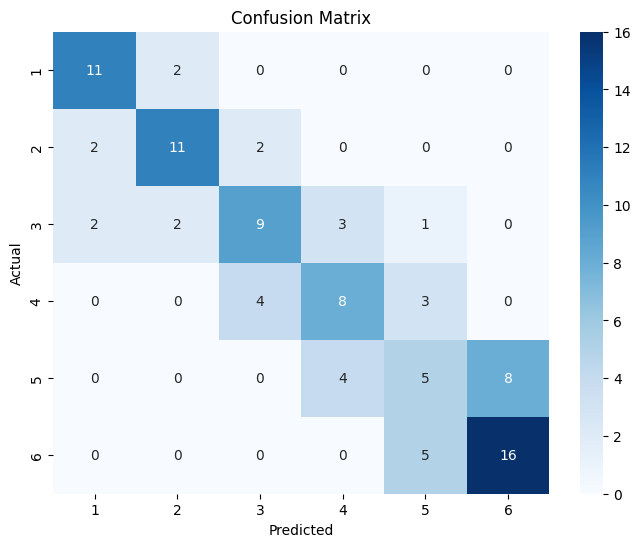

In [25]:
y_true = X_test["score"].tolist()
evaluate(y_true, predicted_scores)